# Projet analyse de données : Velib

We consider the ‘Vélib’ data set, related to the bike sharing system of Paris. The data are loading profiles of the bike stations over one week, collected every hour, from the period Monday 2nd Sept. - Sunday 7th Sept., 2014. The loading profile of a station, or simply loading, is defined as the ratio of number of available bikes divided by the number of bike docks. A loading of 1 means that the station is fully loaded, i.e. all bikes are available. A loading of 0 means that the station is empty, all bikes have been rent.

From the viewpoint of data analysis, the individuals are the stations. The variables are the 168 time steps (hours in the week). The aim is to detect clusters in the data, corresponding to common customer usages. This clustering should then be used to predict the loading profile.


In [1]:
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import decomposition
import pandas as pd
import numpy as np
%matplotlib inline
from pylab import * 
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.cluster import KMeans

In [2]:
loading = pd.read_csv('velibLoading.csv', sep = " ")
loading.head()

Lun-00    Lun-01    Lun-02    Lun-03    Lun-04    Lun-05    Lun-06  \
1  0.038462  0.038462  0.076923  0.038462  0.038462  0.038462  0.038462   
2  0.478261  0.478261  0.478261  0.434783  0.434783  0.434783  0.434783   
3  0.218182  0.145455  0.127273  0.109091  0.109091  0.109091  0.090909   
4  0.952381  0.952381  0.952381  0.952381  0.952381  0.952381  0.952381   
5  0.927536  0.811594  0.739130  0.724638  0.724638  0.724638  0.724638   

     Lun-07    Lun-08    Lun-09  ...    Dim-14    Dim-15    Dim-16    Dim-17  \
1  0.038462  0.107143  0.000000  ...  0.296296  0.111111  0.111111  0.148148   
2  0.434783  0.260870  0.043478  ...  0.043478  0.000000  0.217391  0.130435   
3  0.090909  0.054545  0.109091  ...  0.259259  0.259259  0.203704  0.129630   
4  1.000000  1.000000  1.000000  ...  1.000000  1.000000  0.904762  0.857143   
5  0.724638  0.753623  0.971014  ...  0.227273  0.454545  0.590909  0.833333   

     Dim-18    Dim-19    Dim-20    Dim-21    Dim-22    Dim-23  
1  0.307692  0.076923  0.115385  0.076923  0.153846  0.153846  
2  0.045455  0.173913  0.173913  0.173913  0.260870  0.391304  
3  0.148148  0.296296  0.314815  0.370370  0.370370  0.407407  
4  0.857143  0.857143  0.761905  0.761905  0.761905  0.761905  
5  1.000000  0.818182  0.636364  0.712121  0.621212  0.575758  

[5 rows x 168 columns]

In [3]:
velibAdds = pd.read_csv('velibAdds.csv', sep = " ")
velibAdds.head()

longitude   latitude  bonus              names
1   2.377389  48.886300      0   EURYALE DEHAYNIN
2   2.317591  48.890020      0          LEMERCIER
3   2.330447  48.850297      0    MEZIERES RENNES
4   2.271396  48.833734      0             FARMAN
5   2.366897  48.845887      0   QUAI DE LA RAPEE

# 1 Statistiques descriptives

## 1.1 Exemple sur 16 stations

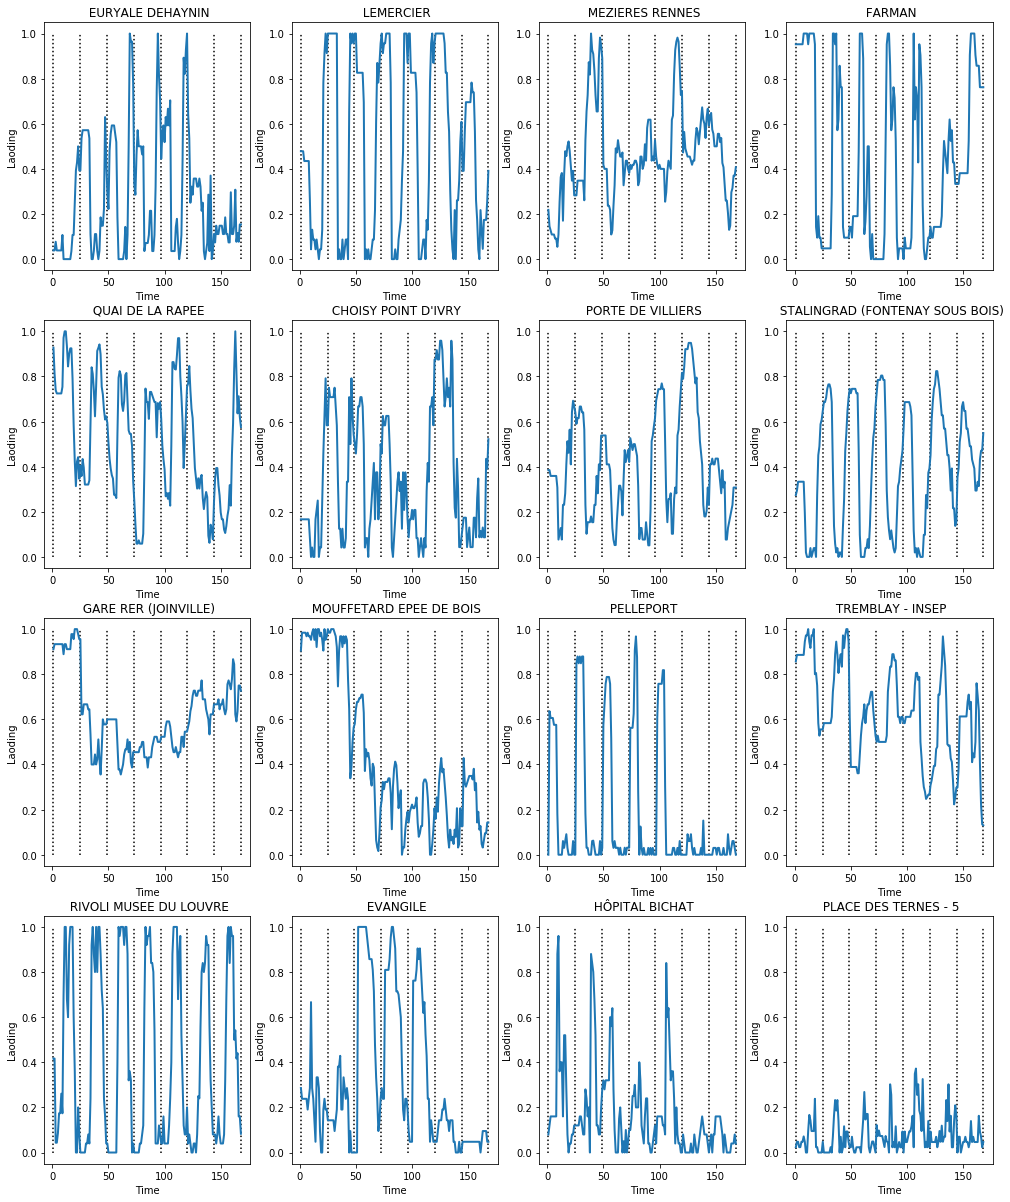

In [4]:
# Graphique de l'état de chargement des stations, les 16 premières

T16prem = loading.iloc[0:16]

p = loading.columns.size
Time = np.linspace(1, p, p)

plt.figure(1,figsize = (17, 21))
for k in range(16):
    ax = plt.subplot(4,4,k+1)
    plt.plot(Time, loading.transpose()[k+1], linewidth = 2)
    plt.xlabel('Time')
    plt.ylabel('Laoding')
    plt.title(velibAdds.names[k+1])
    vlines(x = np.linspace(1, p, 8), ymin = 0, ymax = 1, colors = "black", linestyle = "dotted")
plt.show()

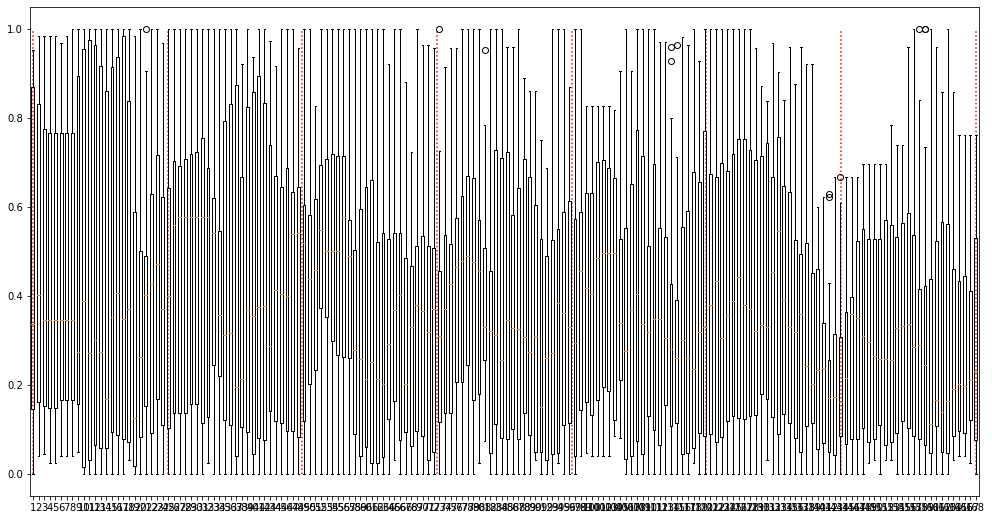

In [5]:
# Boxplot des variables ordonnées chronologiquement, sur les 16 premières stations

p = loading.columns.size
Time = np.linspace(1, p, p)

plt.figure(1,figsize = (17, 9))
plt.boxplot(T16prem.transpose())
vlines(x = np.linspace(1, p, 8), ymin = 0, ymax = 1, colors = "red", linestyle = "dotted")
plt.show()

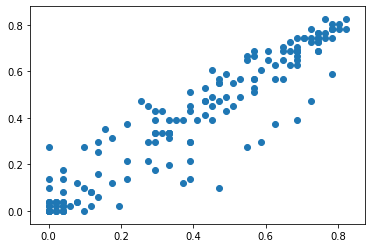

In [6]:
# Affichage du chargement à t en fonction du chargement à t+h (corrélation temporelle), pour les 16 premières stations

station = T16prem.iloc[7]
Station = np.array(station)
plt.scatter(Station,np.concatenate([Station[1:],[Station[0]]]))
plt.show()

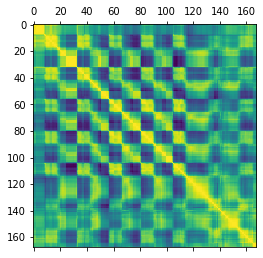

In [7]:
# Matrice de corrélation, pour les 16 premières stations

plt.matshow(T16prem.corr())

## 1.2 Représentation géographique des stations

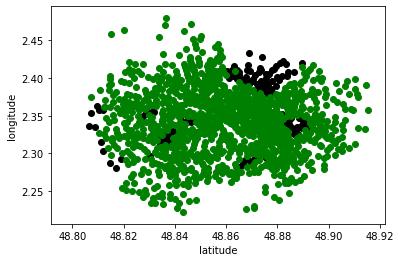

In [8]:
# Affichage géographique avec les stations en hauteur en noir et les autres en vert.

veliAddshills = velibAdds[velibAdds.bonus == 1]
veliAddsnohills = velibAdds[velibAdds.bonus == 0]

plt.figure(2)
plt.scatter(veliAddshills["latitude"],veliAddshills["longitude"],color="black")
plt.scatter(veliAddsnohills["latitude"],veliAddsnohills["longitude"],color="green")
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.show()

### 1.2.1 Cas des stations sur les collines

In [9]:
# Sélection des stations en hauteur

loadinghills = loading[velibAdds.bonus == 1]

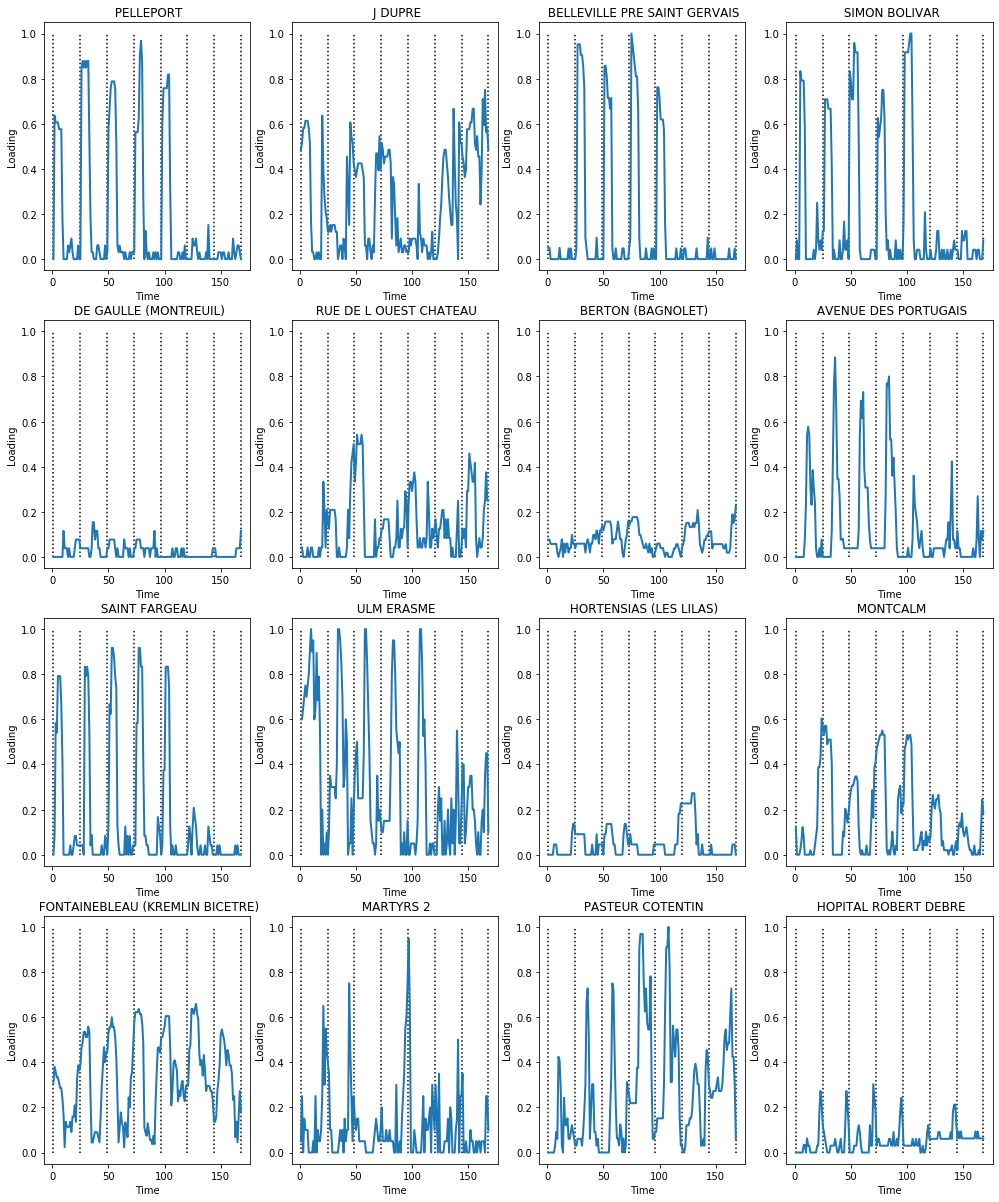

In [10]:
# Graphique de l'état de chargement des stations, 16 affichées ici

p = loadinghills.columns.size
Time = np.linspace(1, p, p)

plt.figure(3,figsize = (17, 21))
for k in range(16):
    ax = plt.subplot(4,4,k+1)
    plt.plot(Time, loadinghills.transpose()[loadinghills.transpose().columns[k]], linewidth = 2)
    plt.xlabel('Time')
    plt.ylabel('Loading')
    plt.title(veliAddshills.names[loadinghills.transpose().columns[k]])
    vlines(x = np.linspace(1, p, 8), ymin = 0, ymax = 1, colors = "black", linestyle = "dotted")
plt.show()

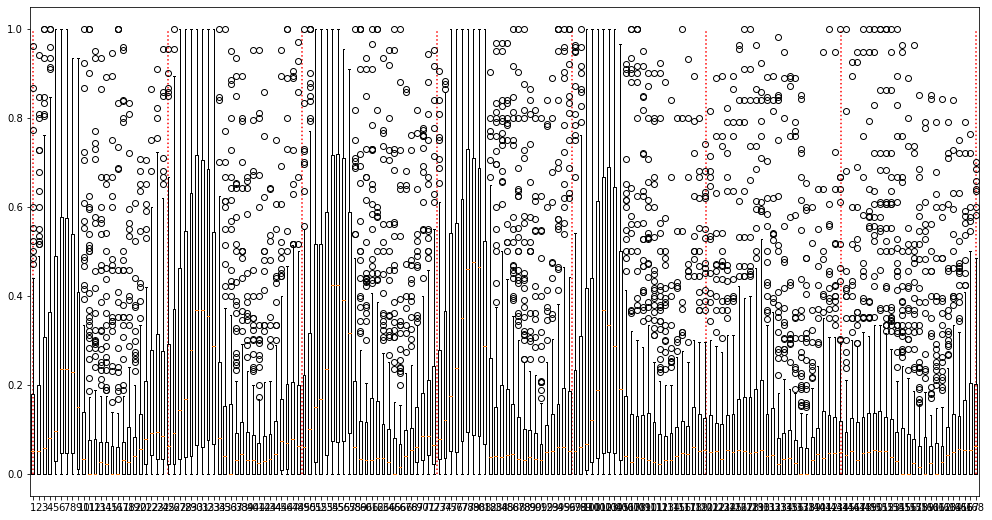

In [11]:
# Boxplot des variables ordonnées chronologiquement, pour les stations en hauteurs

p = loadinghills.columns.size
Time = np.linspace(1, p, p)

plt.figure(1,figsize = (17, 9))
plt.boxplot(loadinghills.transpose())
vlines(x = np.linspace(1, p, 8), ymin = 0, ymax = 1, colors = "red", linestyle = "dotted")
plt.show()

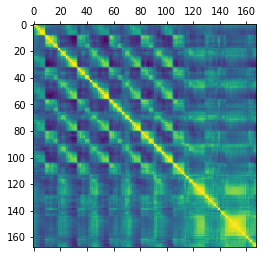

In [12]:
# Matrice de corrélation, pour les stations en hauteurs

plt.matshow(loadinghills.corr())

### 1.2.2 Cas des stations sur du plat

In [13]:
# Sélection des stations sur du plat

loadingnohills = loading[velibAdds.bonus == 0]

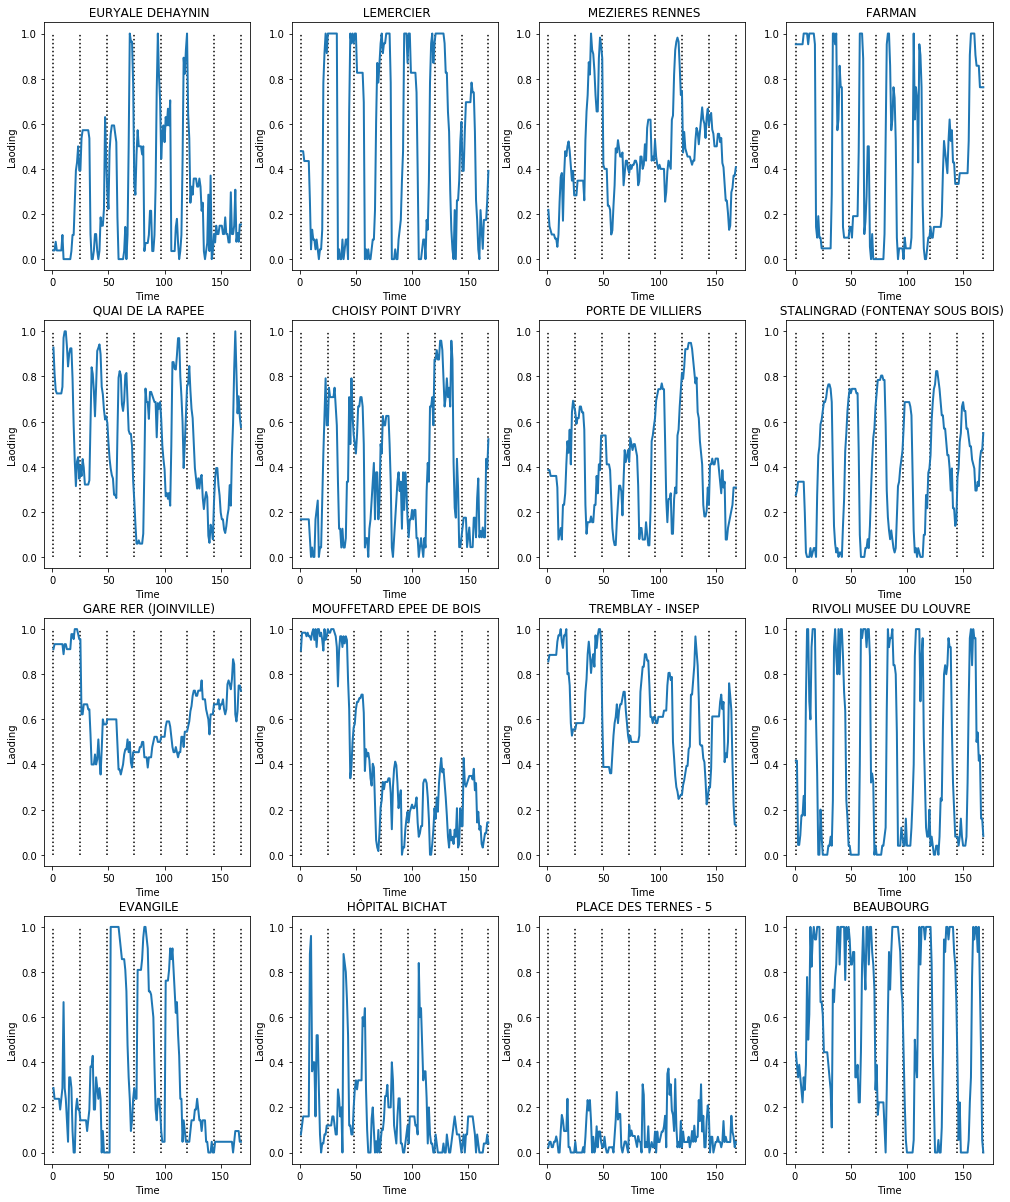

In [14]:
# Graphique de l'état de chargement des stations, 16 affichées ici

p = loadingnohills.columns.size
Time = np.linspace(1, p, p)

plt.figure(3,figsize = (17, 21))
for k in range(16):
    ax = plt.subplot(4,4,k+1)
    plt.plot(Time, loadingnohills.transpose()[loadingnohills.transpose().columns[k]], linewidth = 2)
    plt.xlabel('Time')
    plt.ylabel('Laoding')
    plt.title(veliAddsnohills.names[loadingnohills.transpose().columns[k]])
    vlines(x = np.linspace(1, p, 8), ymin = 0, ymax = 1, colors = "black", linestyle = "dotted")
plt.show()

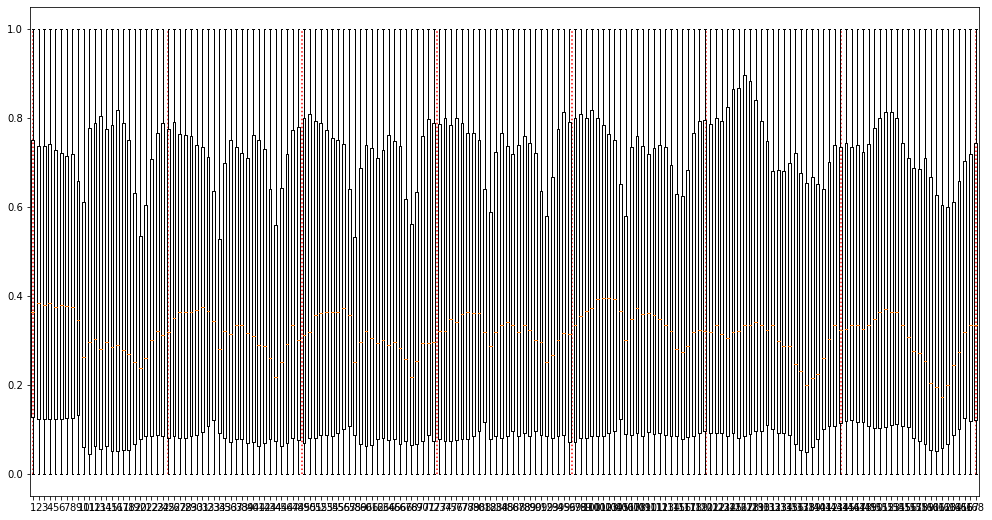

In [15]:
# Boxplot des variables ordonnées chronologiquement, pour les stations sur du plat

p = loadingnohills.columns.size
Time = np.linspace(1, p, p)

plt.figure(1,figsize = (17, 9))
plt.boxplot(loadingnohills.transpose())
vlines(x = np.linspace(1, p, 8), ymin = 0, ymax = 1, colors = "red", linestyle = "dotted")
plt.show()

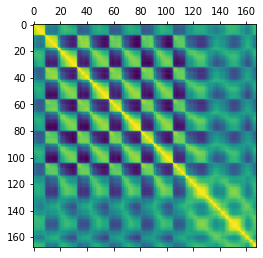

In [16]:
# Matrice de corrélation, pour les stations sur du plat

plt.matshow(loadingnohills.corr())

# 2 ACP

In [17]:
# Fonctions utiles pour la représentation de l'acp

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

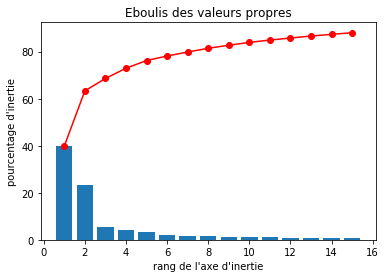

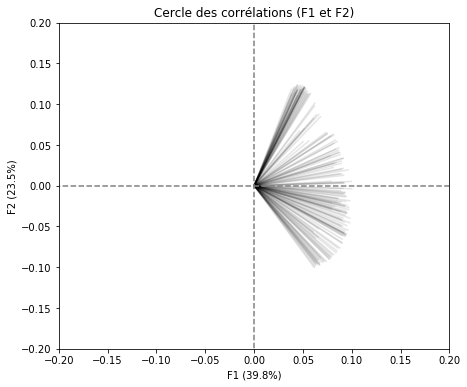

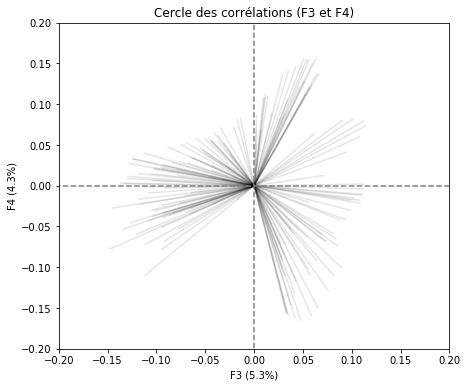

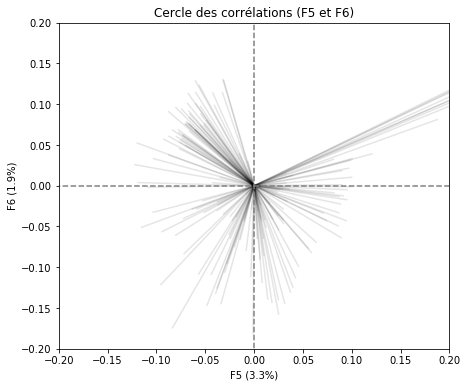

In [45]:
n_comp = 15
loadingR = preprocessing.scale(loading)

pca = decomposition.PCA(n_components=n_comp)
C = pca.fit(loadingR).transform(loadingR)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], lims = (-0.2, 0.2, -0.2, 0.2))

plt.show()

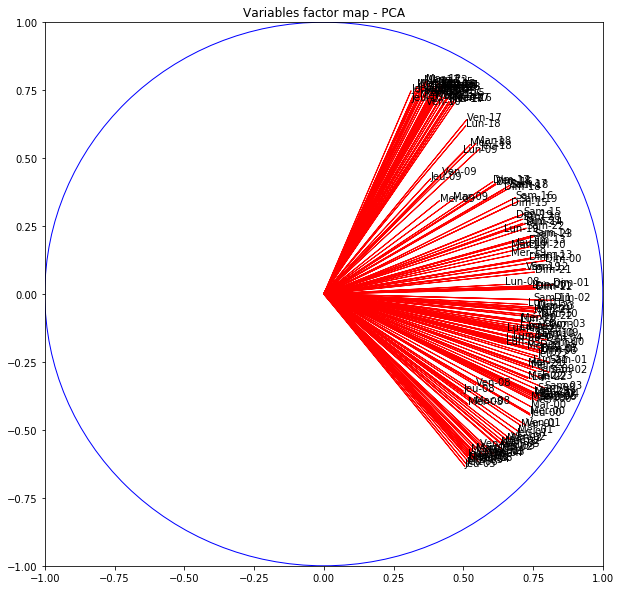

In [19]:
# Autre affichage du cercle de corrélation des variables

coord1 = pca.components_[0] * np.sqrt(pca.explained_variance_[0])
coord2 = pca.components_[1] * np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1, coord2, loading.columns):
    plt.text(i, j, nom)
    plt.arrow(0, 0, i, j, color = ('r'), width = 0.0001)
plt.axis((-1, 1, -1, 1))
#Cercle
c = plt.Circle((0, 0), radius = 1, color = 'b', fill = False)
ax.add_patch(c)
plt.title('Variables factor map - PCA')
plt.show()

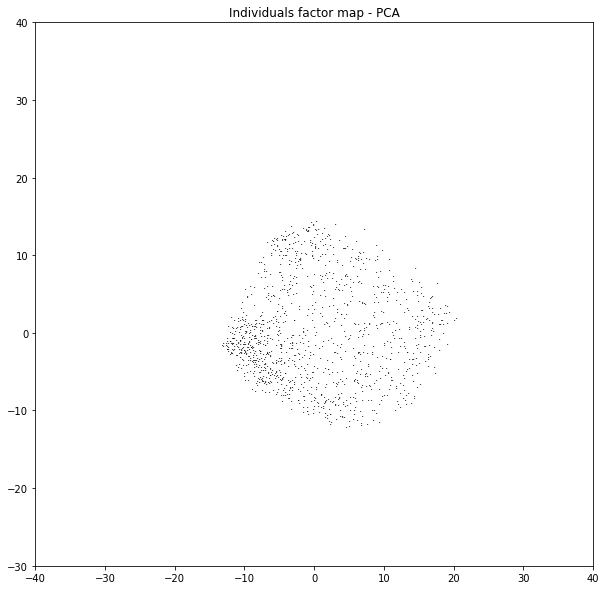

In [20]:
pc1 = C[:,0]
pc2 = C[:,1]
plt.figure(figsize = (10, 10))
for i, j in zip(pc1, pc2):
    plt.text(i, j, ".")
plt.axis((-40, 40, -30, 40))
plt.title('Individuals factor map - PCA')
plt.show()

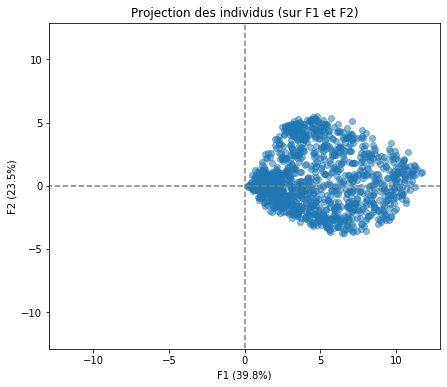

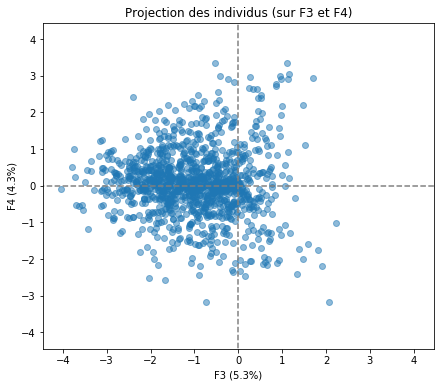

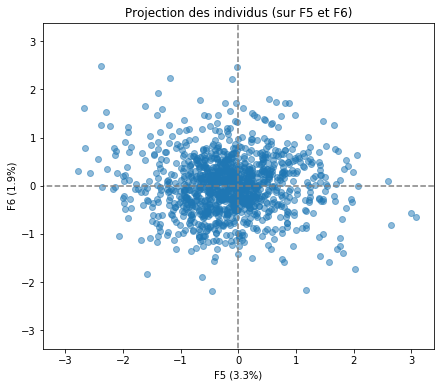

In [21]:
# Projection des individus
X_projected = pca.transform(loading)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], alpha = 0.5)

plt.show()

# 3 Clustering

## 3.1 KMeans

In [22]:
def affichageCourbes(y_pred,n_clusters,moyennes):
    plt.figure(3,figsize = (20, 20))
    for k in range(n_clusters):
        ax = plt.subplot(3,2,k+1)
        ind = np.where(y_pred == k)[0]
        for i in ind:
            y_affichage = loadingR[i]
            plt.plot(Time, y_affichage, linewidth = 0.1, color = "blue")
        plt.plot(Time, moyennes[k], linewidth = 2, color = "red")
        plt.xlabel('Time')
        plt.ylabel('LoadingR')
        plt.title(f"groupe {k}")
        vlines(x = np.linspace(1, p, 8), ymin = ylim()[0], ymax = ylim()[1], colors = "black", linestyle = "dotted")
    plt.show()

### 3.1.1 Clustering sur les données

In [24]:
n_clusters = 5
# Choix des options
kmeans = KMeans(n_clusters=n_clusters, random_state=76876)
# Exécution de l'algorithme
y_pred = kmeans.fit_predict(loadingR)

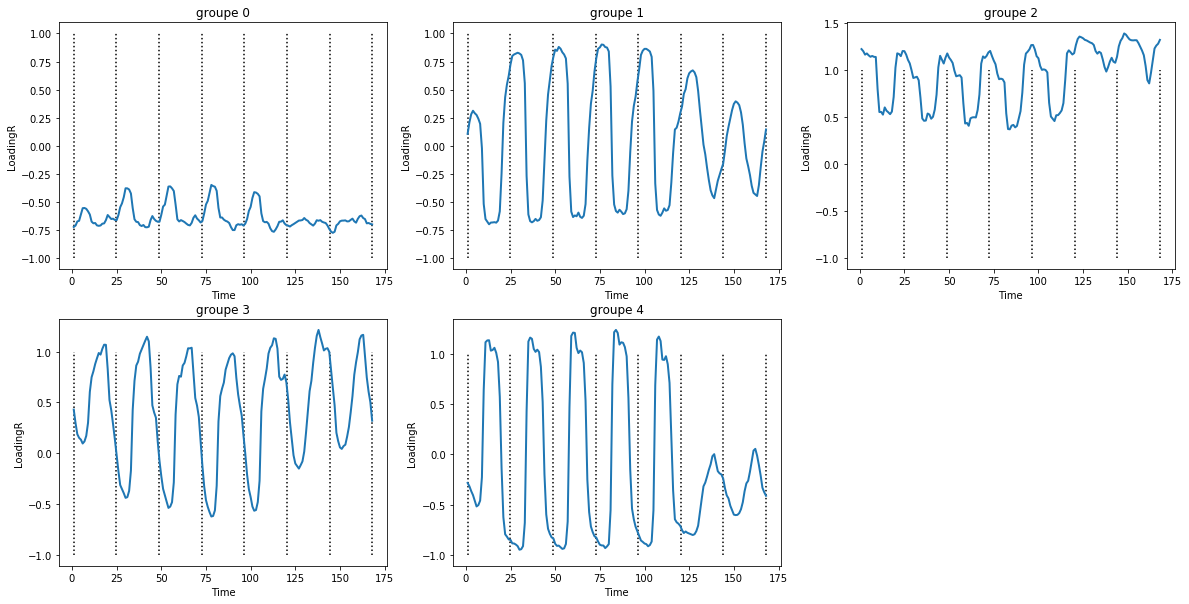

In [25]:
plt.figure(3,figsize = (20, 10))
for k in range(n_clusters):
    ax = plt.subplot(2,3,k+1)
    plt.plot(Time, kmeans.cluster_centers_[k], linewidth = 2)
    plt.xlabel('Time')
    plt.ylabel('LoadingR')
    plt.title(f"groupe {k}")
    vlines(x = np.linspace(1, p, 8), ymin = -1, ymax = 1, colors = "black", linestyle = "dotted")
plt.show()

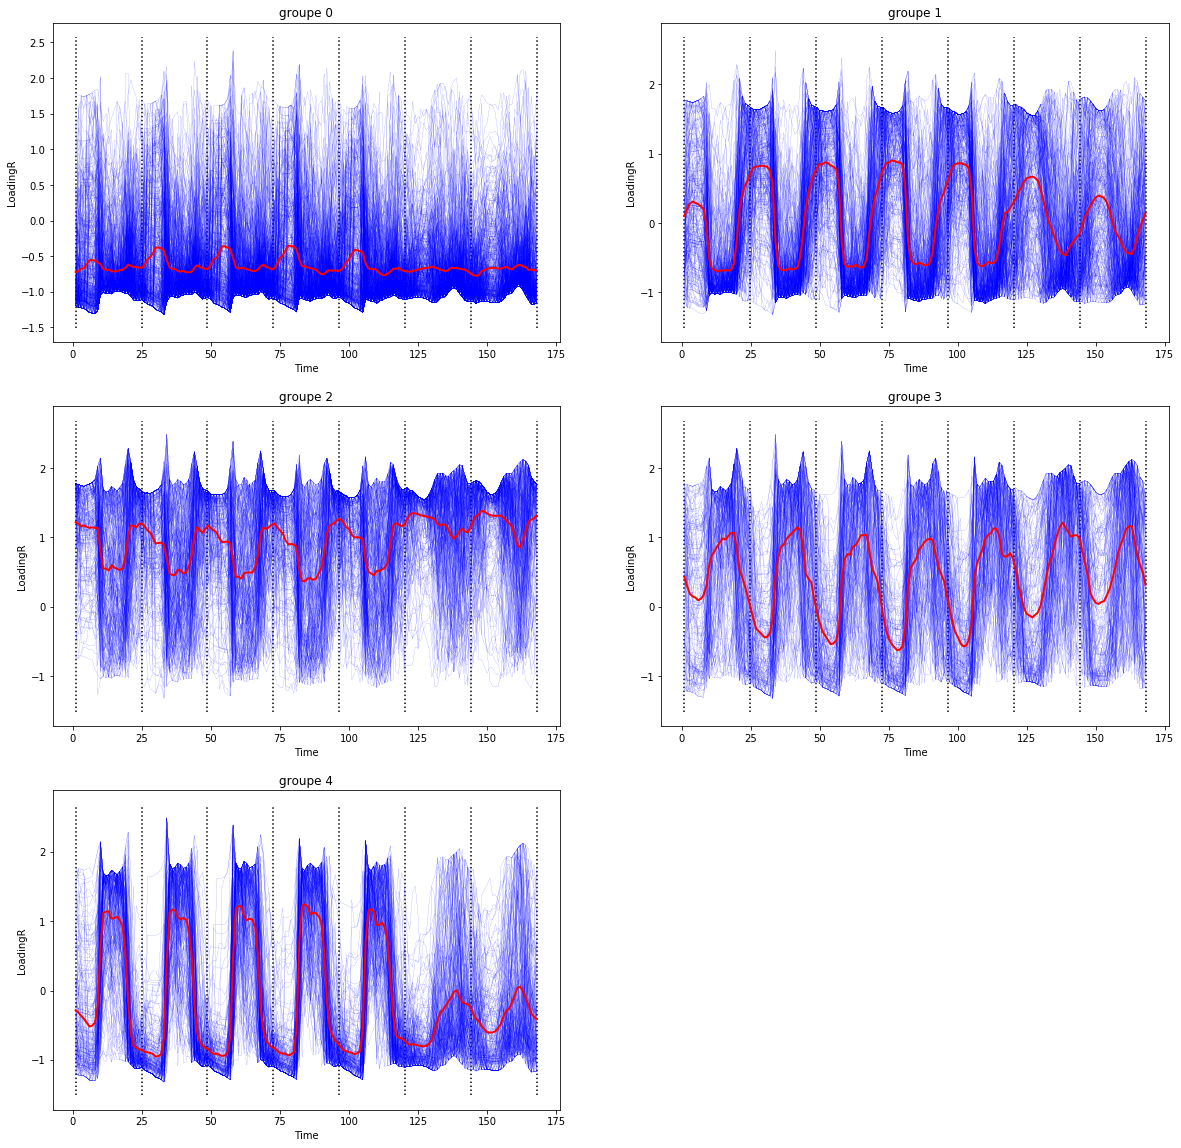

In [26]:
affichageCourbes(y_pred,n_clusters,kmeans.cluster_centers_)

In [27]:
C_pca5 = C[:,:5]

In [28]:
n_clusters = 5
# Choix des options
kmeans_pca5 = KMeans(n_clusters=n_clusters, random_state=76876)
# Exécution de l'algorithme
y_pred_pca5 = kmeans_pca5.fit_predict(C_pca5)
print(y_pred_pca5)

[2 2 3 ... 1 3 3]


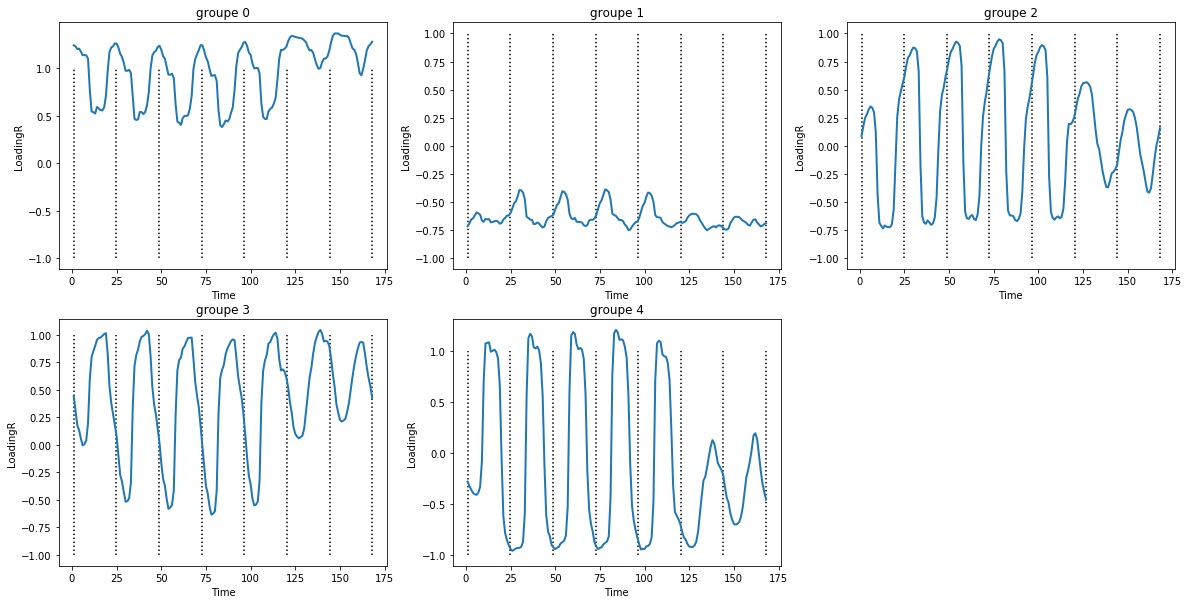

In [29]:
bar = kmeans_pca5.cluster_centers_
complement = np.zeros((n_clusters,10))
bar_inv = pca.inverse_transform(np.hstack((bar,complement)))


plt.figure(3,figsize = (20, 10))
for k in range(n_clusters):
    ax = plt.subplot(2,3,k+1)
    plt.plot(Time, bar_inv[k], linewidth = 2)
    plt.xlabel('Time')
    plt.ylabel('LoadingR')
    plt.title(f"groupe {k}")
    vlines(x = np.linspace(1, p, 8), ymin = -1, ymax = 1, colors = "black", linestyle = "dotted")
plt.show()

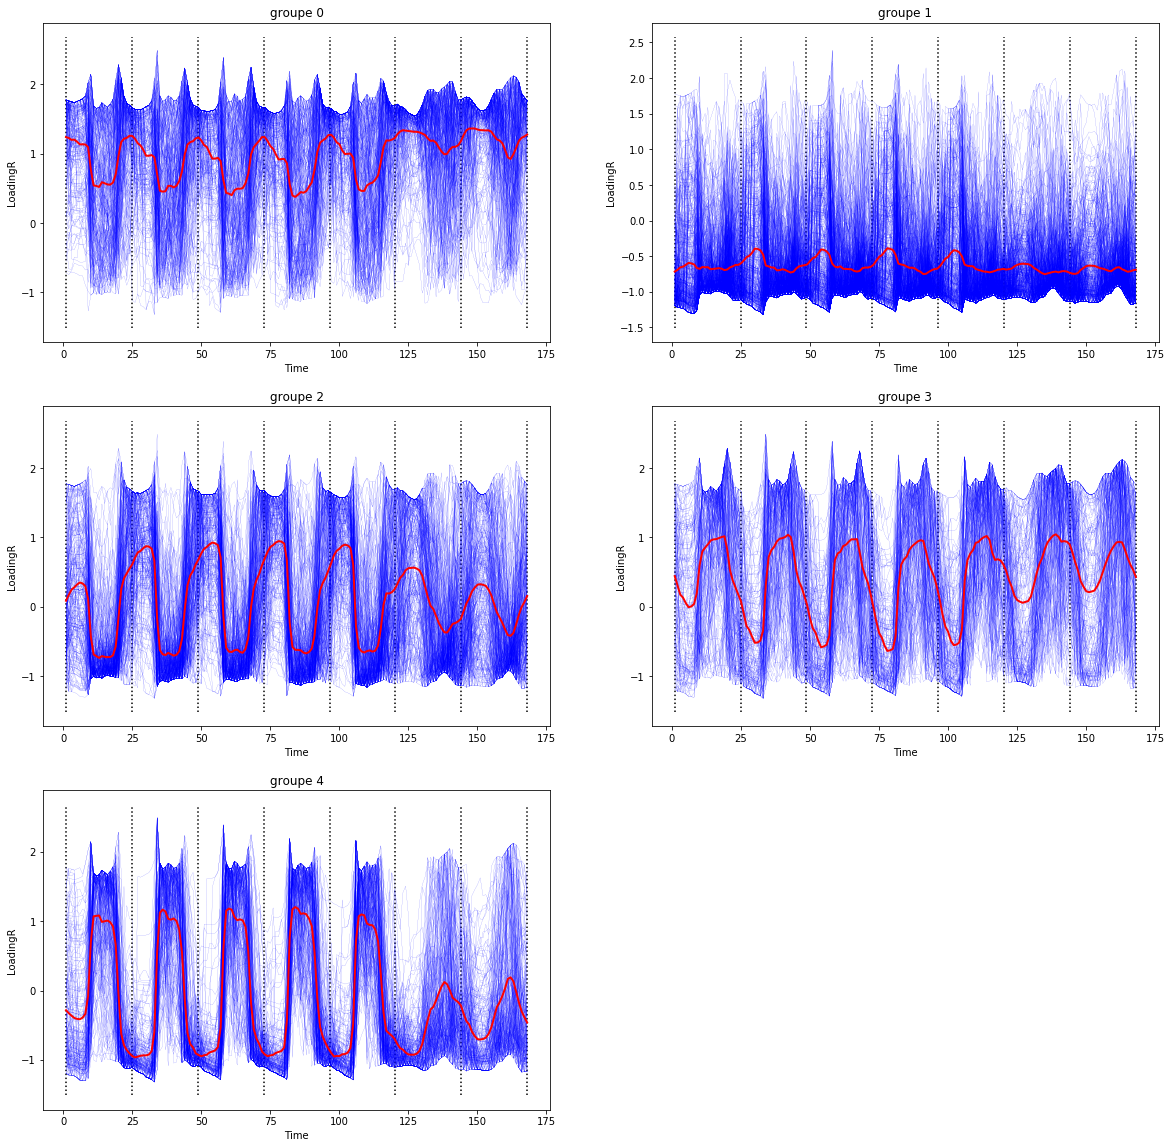

In [30]:
affichageCourbes(y_pred_pca5,n_clusters,bar_inv)

In [31]:
def affichageGeoClusters(velibAdds,y_pred,n_clusters, j = [k for k in range(n_clusters)]):
    plt.figure(figsize=(10,10))
    col = ["black","red","purple","green","blue"]
    for k in range(n_clusters):
        ind = np.where(y_pred == k)[0]
        for i in ind:
            plt.scatter(velibAdds["latitude"].iloc[i],velibAdds["longitude"].iloc[i],color=col[j[k]],s=35)
    plt.xlabel("latitude")
    plt.ylabel("longitude")
    plt.show()

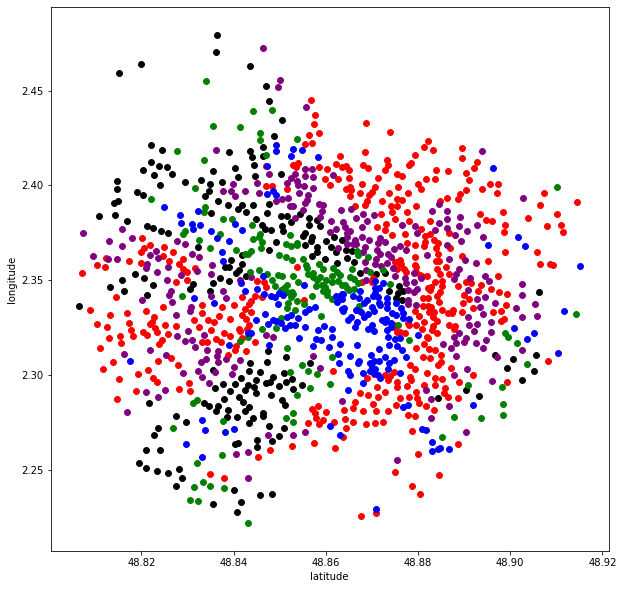

In [32]:
affichageGeoClusters(velibAdds,y_pred_pca5,n_clusters)

In [33]:
def crossTable(classe1, classe2):
    table = pd.crosstab(classe1, classe2, rownames = ['classes ACP'], colnames = ['classes données brutes'])
    a = np.zeros(np.shape(table)[0])
    b = np.zeros(np.shape(table)[0])
    for j in range (0, np.shape(table)[0]):
        for i in range (0, np.shape(table)[0]):
            if (a[j] < table[i][j]):
                a[j] = table[i][j]
                b[j] = i                       
                                             
    print ("")
    print ("max colonne", a)
    print ("j=", b)
    print ("")
    tablebis = np.copy(table)
    for i in range (0, np.shape(table)[0]):
        tablebis[i][:] = table[b[i]][:]        
    return tablebis

In [34]:
crossTable(y_pred,y_pred_pca5)


max colonne [406. 239. 208. 139. 182.]
j= [1. 2. 0. 3. 4.]



array([[406,   1,   0,   0,   1],
       [  0, 239,   0,   0,   0],
       [  0,   0, 208,   0,   0],
       [  0,   2,   5, 139,   3],
       [  0,   0,   0,   3, 182]], dtype=int64)

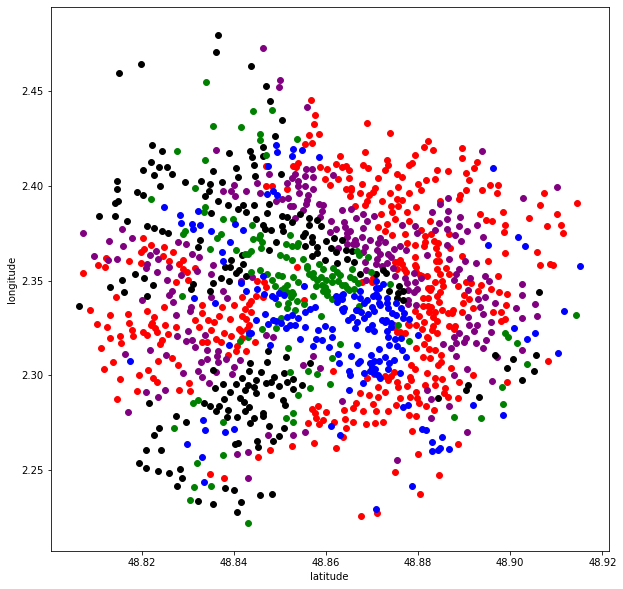

In [35]:
affichageGeoClusters(velibAdds,y_pred,n_clusters, [1, 2, 0, 3, 4])

## Mélange gaussien

In [36]:
from sklearn.mixture import GaussianMixture

In [37]:
gm = GaussianMixture(n_components=n_clusters, random_state=4254)
y_pred_gauss = gm.fit(loadingR).predict(loadingR)

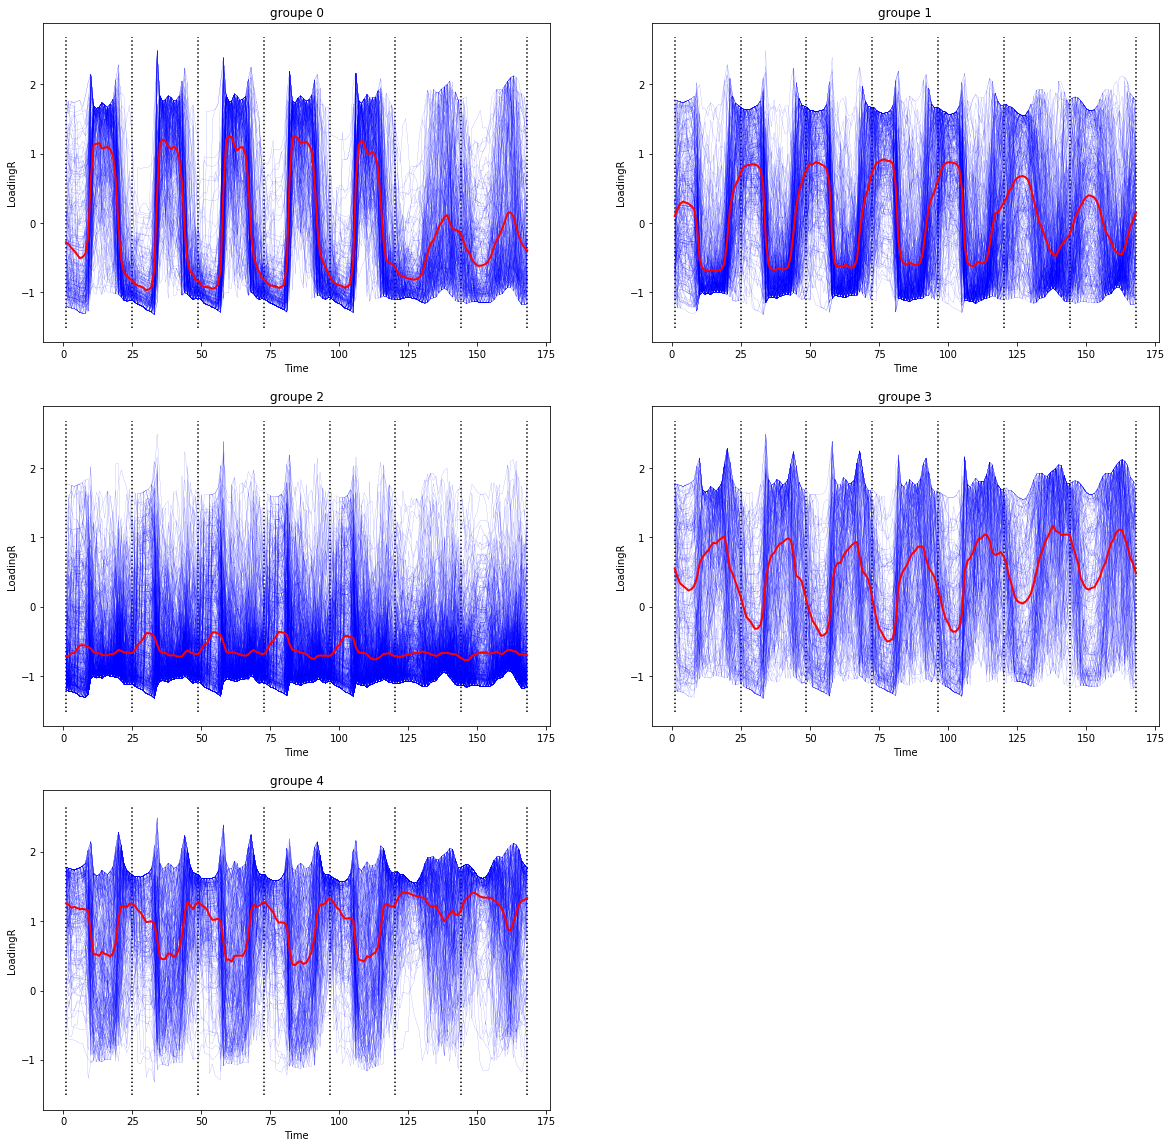

In [38]:
affichageCourbes(y_pred_gauss,n_clusters,gm.means_)

In [39]:
crossTable(y_pred_gauss,y_pred)


max colonne [181. 239. 406. 127. 192.]
j= [4. 1. 0. 3. 2.]



array([[181,   0,   5,   0,   0],
       [  0, 239,   0,   3,   0],
       [  0,   0, 406,   0,   0],
       [ 15,   0,   0, 127,   0],
       [  0,   2,   0,  19, 192]], dtype=int64)

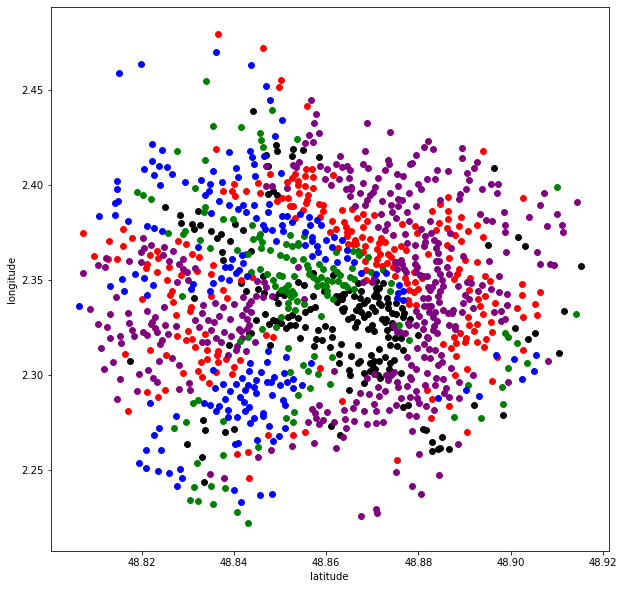

In [40]:
affichageGeoClusters(velibAdds,y_pred_gauss,n_clusters)

In [41]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.metrics import silhouette_score

def affichageSilhouette(f,X):
    plt.figure(figsize=(11, 9))

    for k in (3, 4, 5, 6):
        plt.subplot(2, 2, k - 2)
        method_per_k = [f(n_clusters=k, random_state=42).fit(X) for k in range(3, 7)]
        y_pred = method_per_k[k - 3].labels_
        silhouette_coefficients = silhouette_samples(X, y_pred)
        
        silhouette_scores = [silhouette_score(X, model.labels_) for model in method_per_k]

        padding = len(X) // 30
        pos = padding
        ticks = []
        for i in range(k):
            coeffs = silhouette_coefficients[y_pred == i]
            coeffs.sort()
            cmap = matplotlib.cm.get_cmap("Spectral")
            color = cmap(i / k)
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                              facecolor=color, edgecolor=color, alpha=0.7)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding

        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
        if k in (3, 5):
            plt.ylabel("Cluster")

        if k in (5, 6):
            plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
            plt.xlabel("Silhouette Coefficient")
        else:
            plt.tick_params(labelbottom=False)

        plt.axvline(x=silhouette_scores[k - 3], color="red", linestyle="--")
        plt.title("$k={}$".format(k), fontsize=16)
    plt.show()

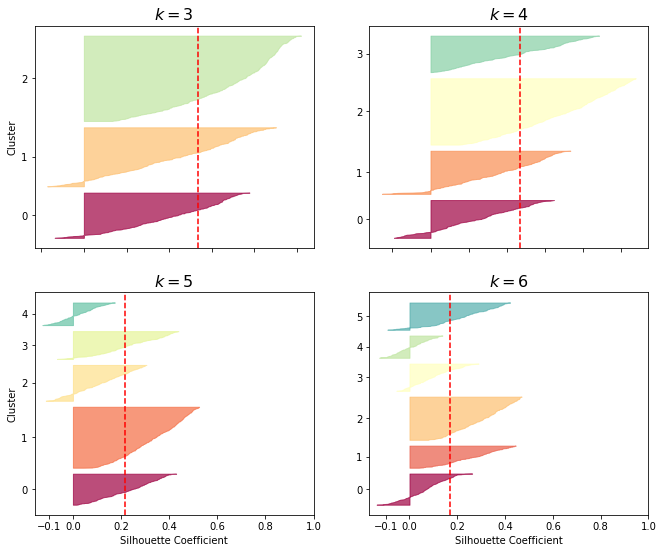

In [42]:
affichageSilhouette(KMeans,loadingR)

In [43]:
import numpy as np
quad_point = np.array ( ( \
    0.112701665379258311482073460022, \
    0.5, \
    0.887298334620741688517926539978 ) )
for a,b in zip(quad_point,quad_point):
    print(a,b)

0.11270166537925831 0.11270166537925831
0.5 0.5
0.8872983346207417 0.8872983346207417
